# Mistaken Mice notebook

2020 NMA academy project, mistaken mice group, pod 173 antique cicada

# Import packages and functions

In [8]:
# to import the functions we wrote, clone the git repo
#!git clone https://github.com/jorgeerrz/mistaken_mice.git
#%cd mistaken_mice
#alternatively, run the notebook locally, then just comment the lines above

from filter import *
from summarise_dataset import *
from PCA_fun import neurons_PCA
from GLM import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading of Steinmetz data

In [9]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)


In [10]:
# skip if you already downloaded the data
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [11]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))


# Filter the data

In [12]:
# need to loop over all sessions to pass as input to summarise_data function in next step
first_session_filtered_VISp = filter_spikes(alldat,0,'VISp') 
first_session_filtered = filter_spikes(alldat,0) 
print(np.shape(first_session_filtered['spks']))

(734, 10, 250)


# Summarise the filtered data

{'n_neurons': array([ 734., 1070.,  619., 1769., 1077., 1169.,  584., 1156.,  788.,
        1172.,  857.,  698.,  983.,  756.,  743.,  474.,  565., 1089.,
         606.,  899.,  578.,  646., 1268., 1337.,  885., 1056.,  563.,
         549.,  750.,  942.,  977.,  522.,  613.,  781.,  795.,  680.,
        1055.,  805., 1348.]),
 'n_trials': array([214., 251., 228., 249., 254., 290., 252., 250., 372., 447., 342.,
        340., 300., 268., 404., 280., 224., 316., 247., 235., 124., 444.,
        151., 187., 261., 178., 253., 142., 128., 143., 237., 260., 191.,
        296., 311., 258., 181., 199., 343.]),
 'n_timebins': array([250., 250., 250., 250., 250., 250., 250., 250., 250., 250., 250.,
        250., 250., 250., 250., 250., 250., 250., 250., 250., 250., 250.,
        250., 250., 250., 250., 250., 250., 250., 250., 250., 250., 250.,
        250., 250., 250., 250., 250., 250.])}

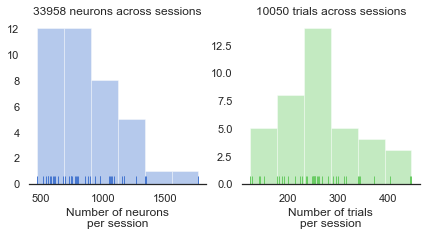

In [13]:
summarise_dataset(alldat) # should be filtered data, but alldat is used here as an example


# Change the time bin
Optional step

In [14]:
dat = first_session_filtered
NT = dat['spks'].shape[-1]
minT = 50
maxT = 130
NN = dat['spks'].shape[0]

droll = np.reshape(dat['spks'][:,:,minT:maxT], (NN,-1))

dat['spks'][:,:,minT:maxT].mean(axis=2).shape


(734, 10)

# Principal Component Analysis
For now, just one session

In [15]:
#neurons_PCA(first_session_filtered,0.1,50,130)

# General Linear Model 

In [16]:
# session = 11
# filtered = filter_spikes(alldat,session)
# dat = neurons_PCA( filter_spikes(alldat,session),0.1,50,130)
# plt.plot(dat['PCs'].T)
# plt.xlabel('Trial')
# plt.ylabel('Component value')
# dat['PCs'].shape
# plt.plot(filter_spikes(alldat,session)['chcs'],linewidth=3,c='red')


In [20]:
[np.sum(np.isin(alldat[x]['brain_area'],["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"])) for x in [11]]

[145]

0.21974967561640354
0.17901430474085372
0.15042547624553312
0.12979976653214448
0.11853882958014156


(10, 10)

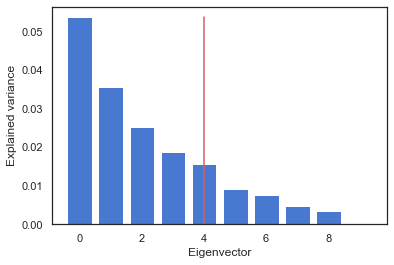

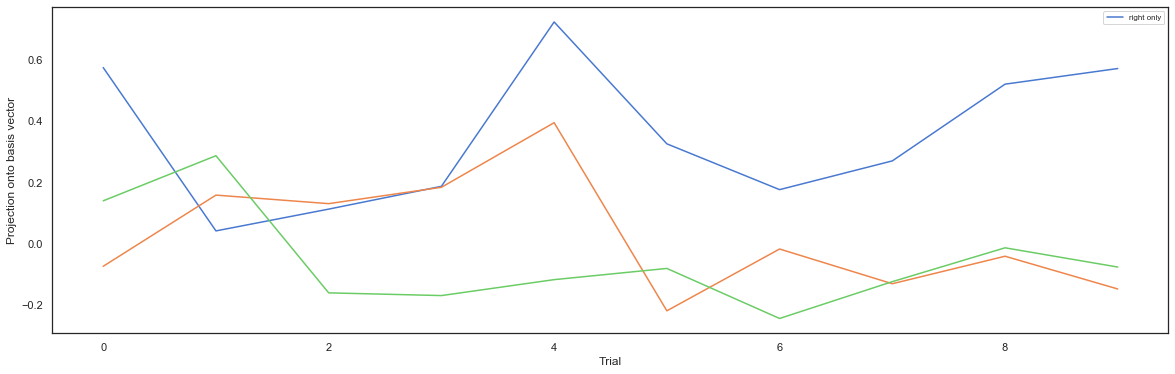

In [59]:
session = 0
brain_areas =[ "VISam", "VISl", "VISp", "VISpm", "VISrl"]
#brain_areas = ['MOp']
filtered = filter_spikes(alldat,session,unfair_only=True,brain_area=brain_areas)
dat = neurons_PCA(filtered,0.1,0,250)
plt.plot(dat['PCs'][0,:])
plt.plot(dat['PCs'][1,:])
plt.plot(dat['PCs'][2,:])

print(np.std(dat['PCs'][0,:]))
print(np.std(dat['PCs'][1,:]))
print(np.std(dat['PCs'][2,:]))
print(np.std(dat['PCs'][3,:]))
print(np.std(dat['PCs'][4,:]))


plt.xlabel('Trial')
plt.ylabel('Projection onto basis vector')
dat['PCs'].shape

In [60]:

#print(dat['PCs'].shape)
#print(filtered['chcs'].shape)
    
    
lambda_L2 = 1
penalty = "l2"

#l1args = {'solver':"saga",'max_iter':5000}
l1args = {}


#logreg = GLM_logistic(dat['PCs'].T, filtered['chcs'], pen = penalty, lambda_L2 = lambda_L2)

logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args).fit(dat['PCs'].T, filtered['chcs'])

# plt.gca().set_xlabel('Feature')
# print(logreg.score(dat['PCs'].T, filtered['chcs']))

#from sklearn.linear_model import *
#logreg = LogisticRegressionCV(dat['PCs'].T, filtered['chcs'])

from sklearn.model_selection import *
#from sklearn import cross_validation

#accuracies = LogisticRegression(penalty='l2'),dat['PCs'].T, filtered['chcs'], cv=5, verbose=1) # k=8 crossvalidation
splitter = LeaveOneOut()
splits = splitter.split(dat['PCs'].T)

accuracies = cross_val_score(logreg,dat['PCs'].T, filtered['chcs'], cv=splits, verbose=1) # k=8 crossvalidation
print(accuracies)
print(accuracies.sum())
print(accuracies.mean())

ysplits = [filtered['chcs'][test_index][0] for train_index, test_index in splitter.split(dat['PCs'].T)]
#print(np.mean(filtered['chcs']==1))
print(logreg.predict(dat['PCs'].T))


[1. 1. 0. 1. 1. 1. 1. 1. 0. 1.]
8.0
0.8
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [ ]:
ax = plt.subplot()
ax.plot()
ax.stem(logreg.coef_.squeeze(), use_line_collection=True)


In [ ]:
x = np.array([[1, 2, 3],[4, 5, 6],[7, 8, 9],[10, 11, 12]])
y = np.array([0, 1, 0])
logreg = GLM_logistic(x.T, y, pen = "l2", lambda_L2 = 1)
plot_weights({"Model":logreg})

x.T.shape

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


Session# 0 accuracy mean= 0.8
Session# 1 accuracy mean= 0.6
Session# 2 accuracy mean= 0.6190476190476191
Session# 3 accuracy mean= 0.7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


ValueError: Found array with 0 feature(s) (shape=(21, 0)) while a minimum of 1 is required.

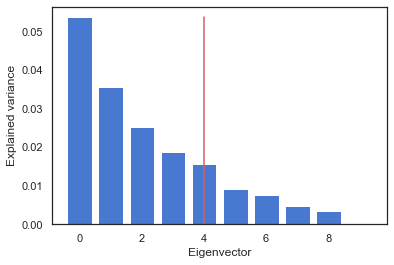

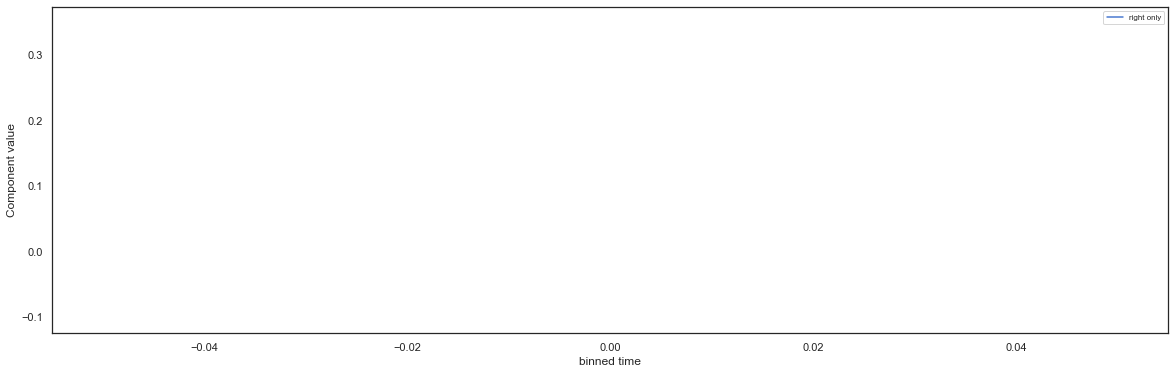

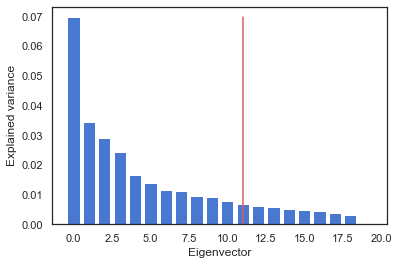

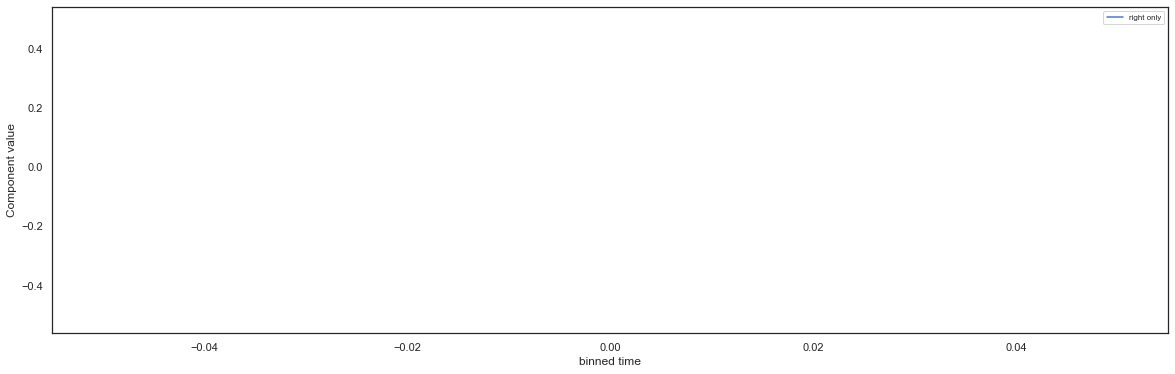

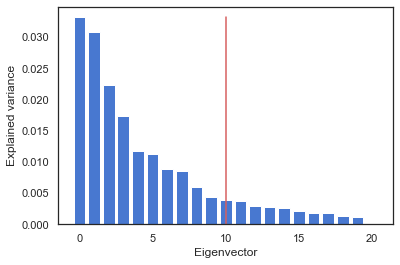

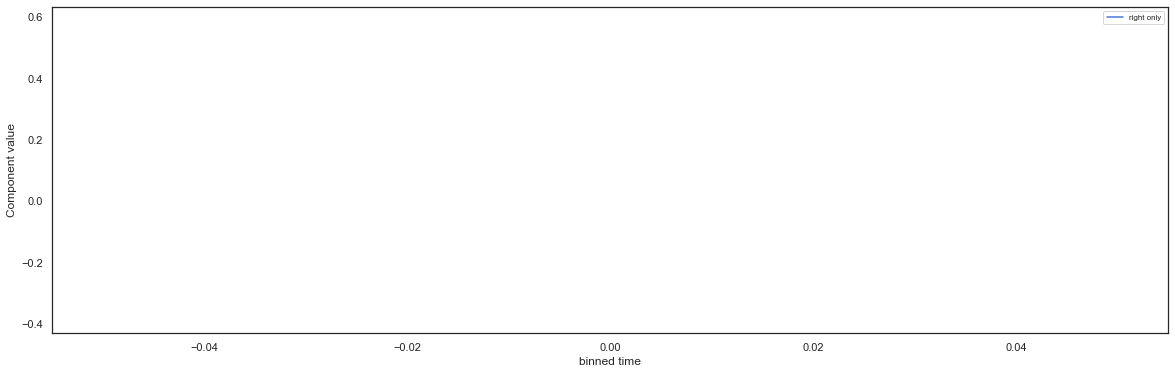

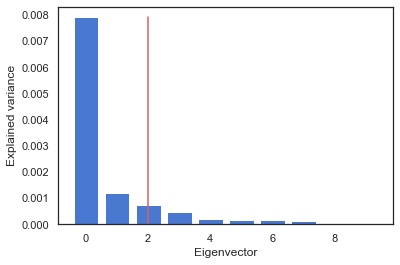

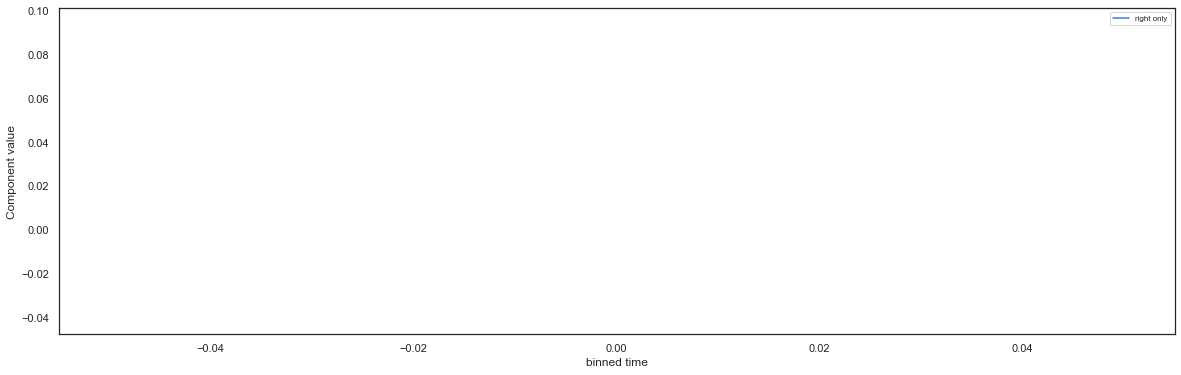

In [58]:
brain_areas =[ "VISam", "VISl", "VISp", "VISpm", "VISrl"]
for session in range(len(alldat)):
    if np.sum(np.isin(alldat[session]['brain_area'],["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"]))>0:
        filtered = filter_spikes(alldat,session,unfair_only=True,brain_area=brain_areas)
        dat = neurons_PCA(filtered,0.1,0,250)
        lambda_L2 = 1
        penalty = "l2"
        l1args = {}
        logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args).fit(dat['PCs'].T, filtered['chcs'])
        splitter = LeaveOneOut()
        splits = splitter.split(dat['PCs'].T)
        accuracies = cross_val_score(logreg,dat['PCs'].T, filtered['chcs'], cv=splits, verbose=1) # k=8 crossvalidation
        print("Session# "+ str(session)+" accuracy mean= "+str(accuracies.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Bin 0 to 25 accuracy mean= 0.5416666666666666
Bin 25 to 50 accuracy mean= 0.5416666666666666


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished


Bin 50 to 75 accuracy mean= 0.5833333333333334
Bin 75 to 100 accuracy mean= 0.7083333333333334


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished


Bin 100 to 125 accuracy mean= 0.875
Bin 125 to 150 accuracy mean= 0.8333333333333334


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Bin 150 to 175 accuracy mean= 0.875
Bin 175 to 200 accuracy mean= 0.75


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished


Bin 200 to 225 accuracy mean= 0.75
Bin 225 to 250 accuracy mean= 0.7083333333333334


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished


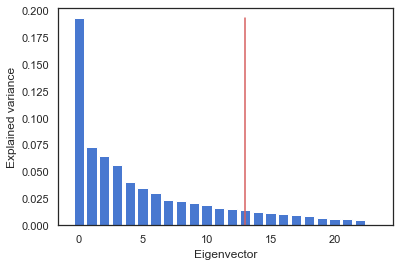

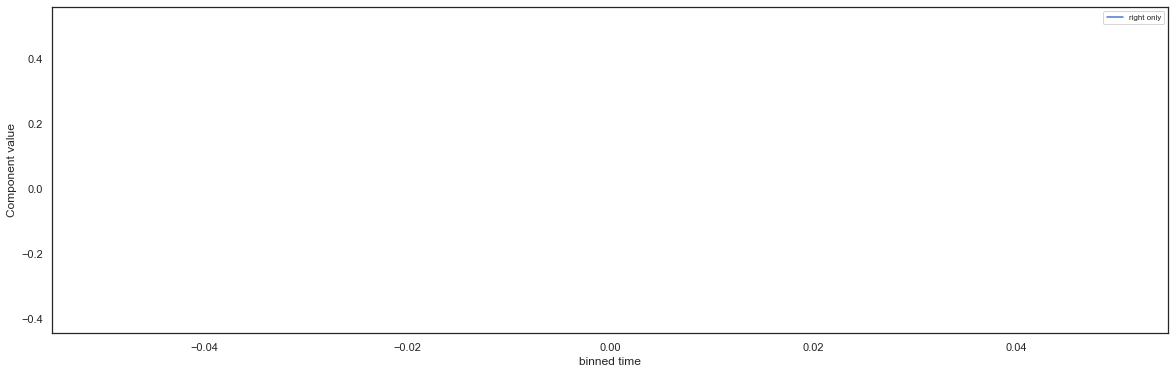

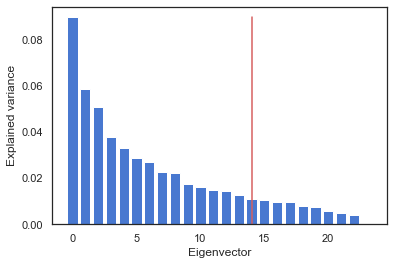

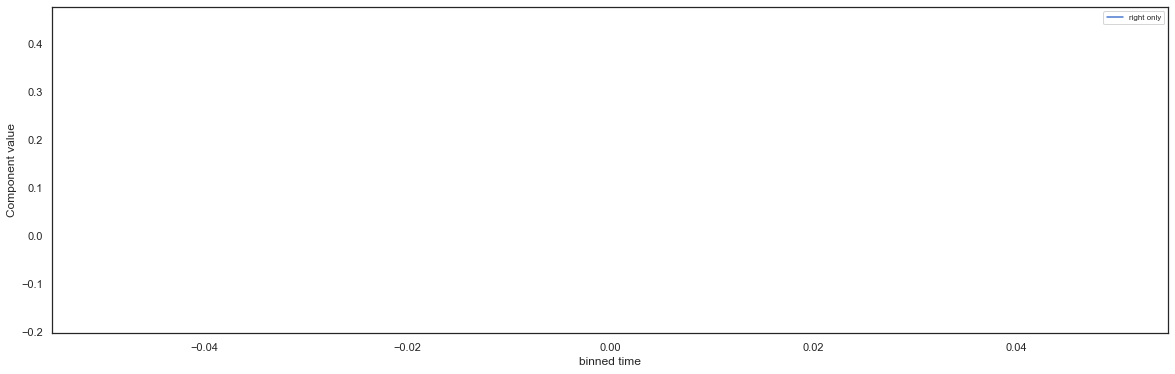

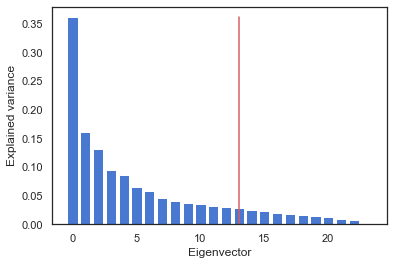

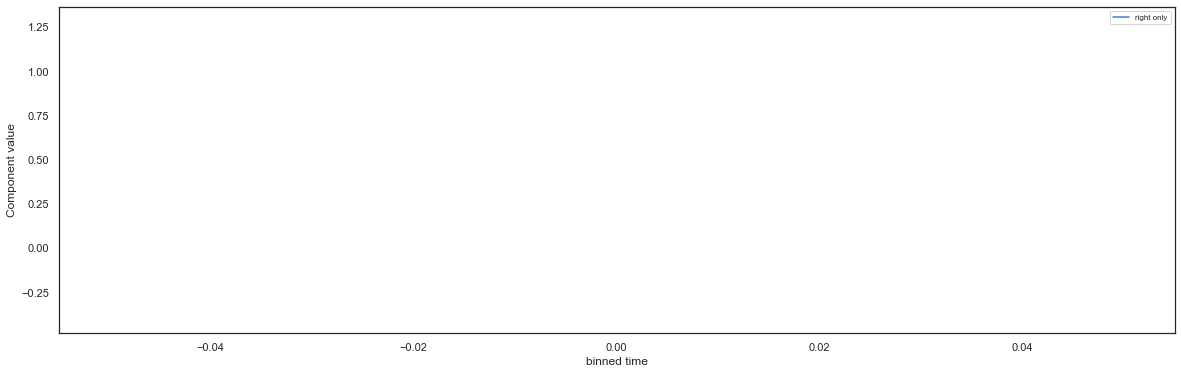

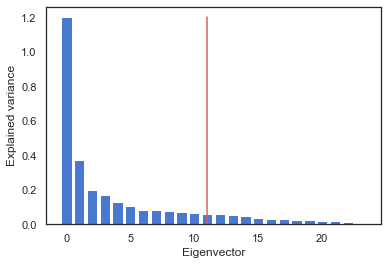

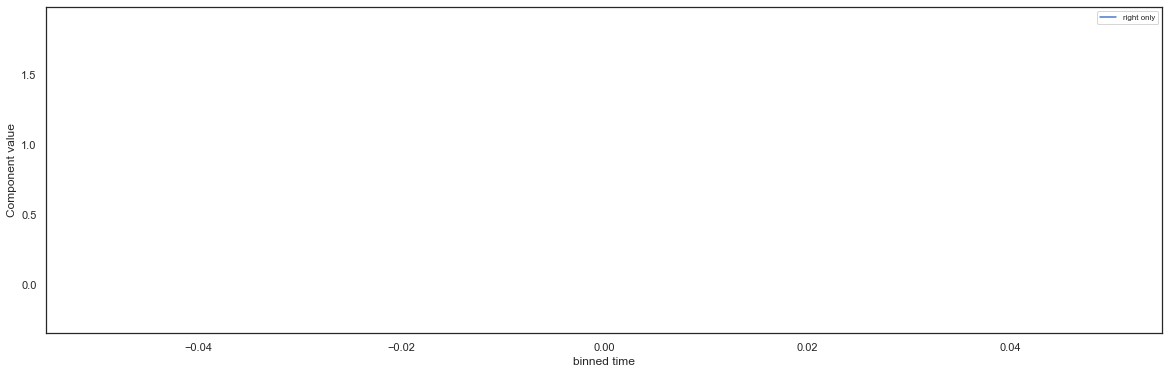

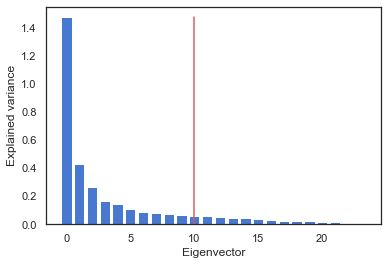

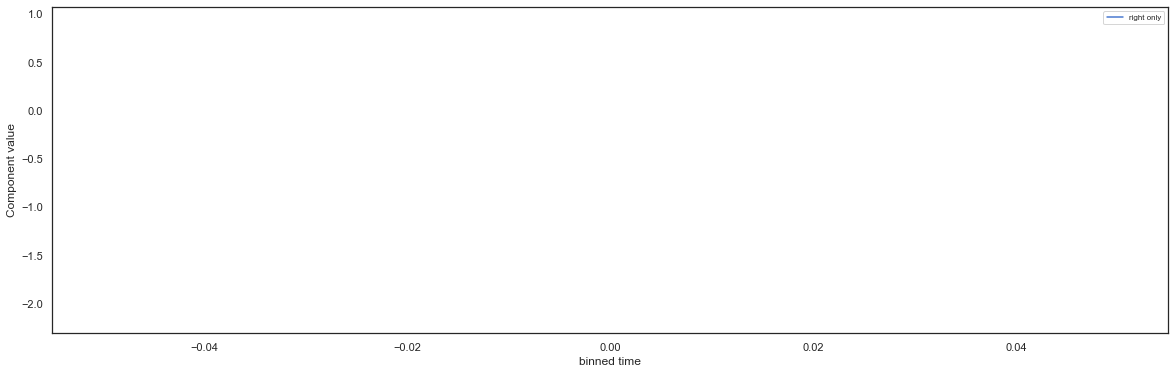

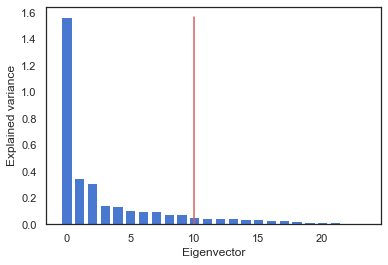

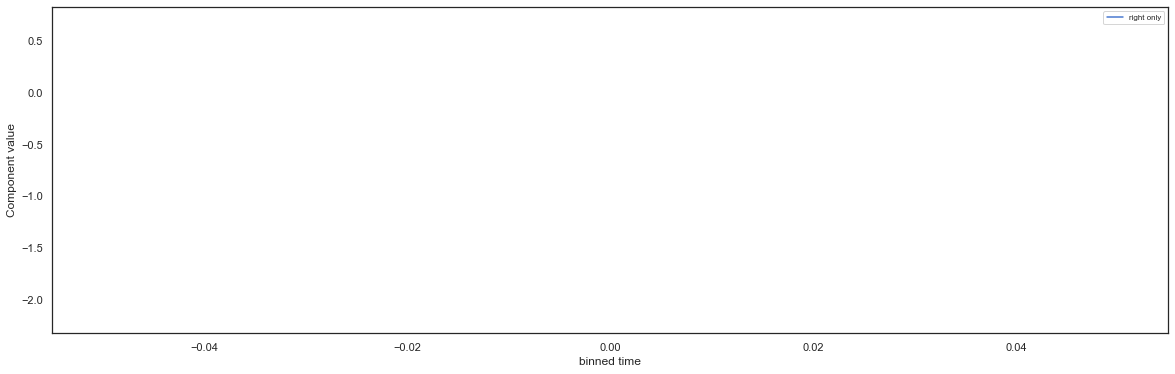

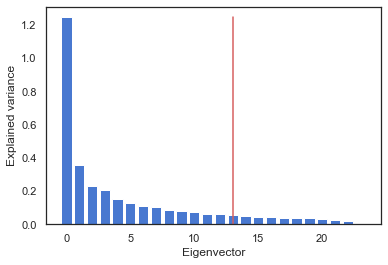

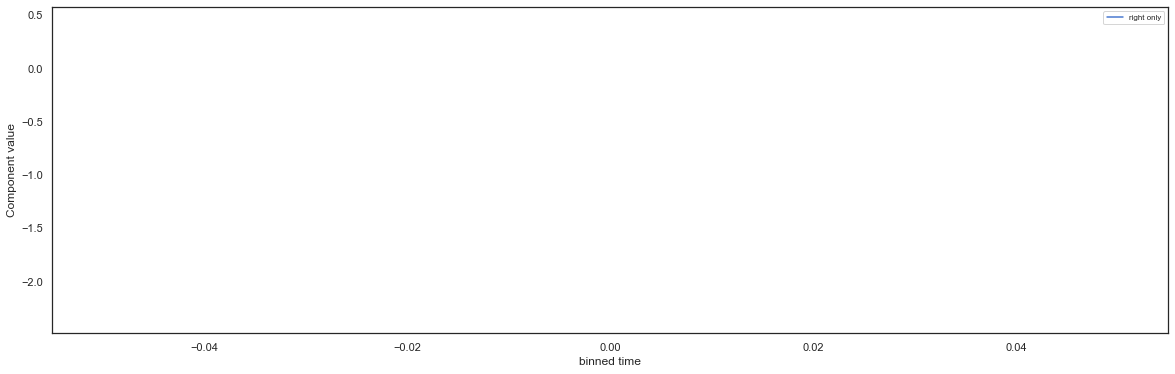

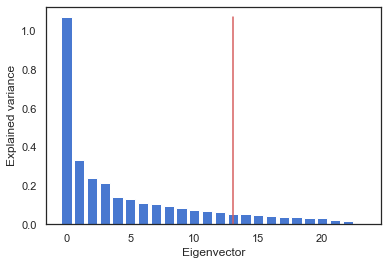

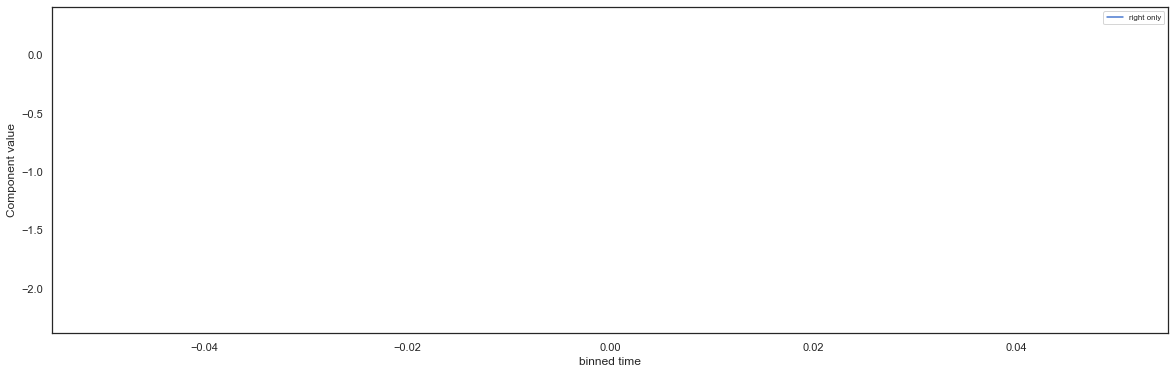

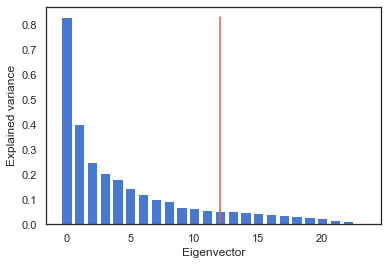

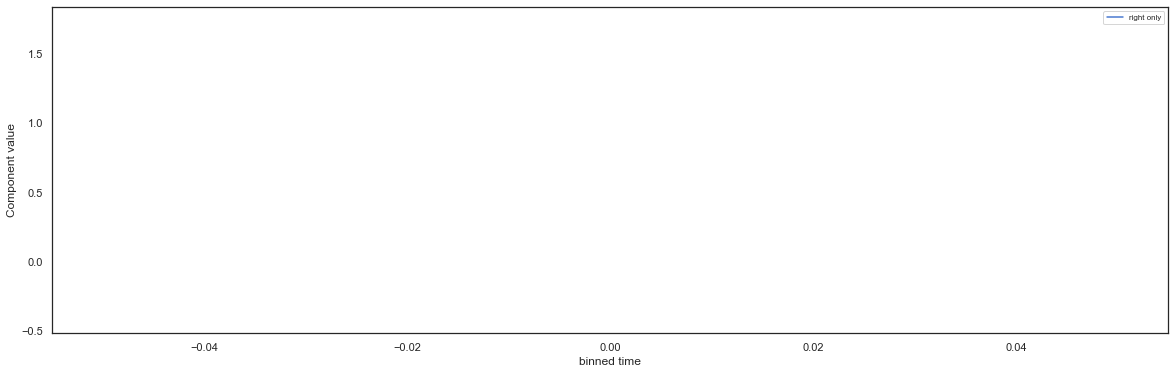

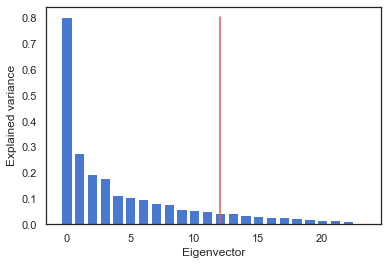

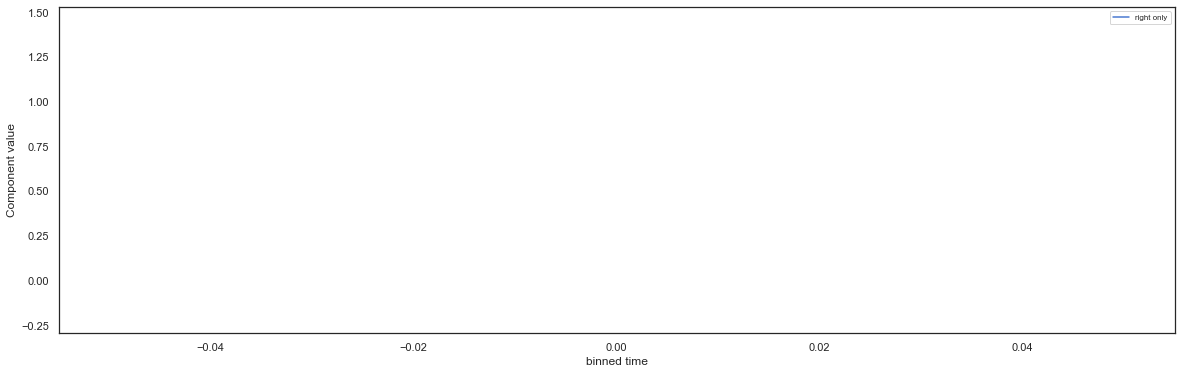

In [75]:
binl = 25
bins = [x for x in range(0,250,binl)]

for bin in bins:
    session = 10
    brain_areas = ["MOp"]
    filtered = filter_spikes(alldat,session,unfair_only=True,brain_area=brain_areas)
    dat = neurons_PCA(filtered,0.1,bin,bin+binl)
    lambda_L2 = 1
    penalty = "l2"
    l1args = {}
    logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args).fit(dat['PCs'].T, filtered['chcs'])
    splitter = LeaveOneOut()
    splits = splitter.split(dat['PCs'].T)
    accuracies = cross_val_score(logreg,dat['PCs'].T, filtered['chcs'], cv=splits, verbose=1) # k=8 crossvalidation
    print("Bin "+str(bin)+" to "+str(bin+binl)+" accuracy mean= "+str(accuracies.mean()))

[0, 25, 50, 75, 100, 125, 150, 175, 200, 225]